<a href="https://colab.research.google.com/github/happyfranc/ml_project/blob/main/%08DL_project1_v2_%EB%B0%95%EC%9D%B4%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

생육 기간 예측 프로젝트

목적 및 배경 : 한 쌍의 이미지를 입력받아 작물의 생육 기간을 예측하는 모델 개발

데이터 정보 및 학습 진행 방식 : DACON "생육 기간 예측 경진대회" 데이터

2개 작물(청경채, 적상추)에 대한 생육 기간 경과일자별 이미지 데이터 저장
- 학습 : 753개(청경채 353개, 적상추 400개)
- 테스트 : 307개(청경채 139개, 적상추 168개)


작물별 이미지 2장씩을 다양하게 조합하여 2장의 이미지간 경과일을 기준으로 학습 및 평가 진행 예정

모델 평가 기준 : RMSE(Root Mean Squared Error)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os
import random

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch import nn
from torchvision.transforms import ToTensor
from torchvision import transforms
from tqdm.auto import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# seed 고정
def seed_everything(seed):
    # 파이토치 및 넘파이, random 등 관련 모듈에 대한 seed 일괄 설정
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed_everything(2048)

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

lr = 0.00005
epochs = 10
batch_size = 64
valid_batch_size = 50 ## 확인

In [6]:
# 파일 path
train_path = '/content/drive/MyDrive/ds_study/data/train_dataset'
test_path = '/content/drive/MyDrive/ds_study/data/test_dataset'

In [7]:
# Data resize 저장 함수
def data_resize(species_nm,root_path):
  os.mkdir(root_path +'/'+ species_nm + '_resize')
  for sub_path in os.listdir(root_path +'/'+ species_nm): # 서브 폴더 생성
    os.mkdir(root_path +'/'+ species_nm + '_resize/' + sub_path)
    for image_path in glob(root_path +'/'+ species_nm + '/' + sub_path + '/*'): # 이미지 resize 및 저장
      image_file_name = image_path.split('/')[-1]
      img = Image.open(image_path)
      img = img.resize((224, 224))
      img.save(root_path +'/'+ species_nm + '_resize/' + sub_path + '/' + image_file_name)

In [8]:
# BC train
#data_resize('BC',train_path)

In [9]:
# LT train
#data_resize('LT',train_path)

In [10]:
# BC test
#data_resize('BC',test_path)

In [11]:
# LT test
#data_resize('LT',test_path)

In [12]:
print(len(glob(train_path + '/BC/**/**')),len(glob(train_path + '/BC_resize/**/**')))

353 353


In [13]:
print(len(glob(train_path + '/LT/**/**')),len(glob(train_path + '/LT_resize/**/**')))

400 400


In [14]:
# 파일 이름에서 날짜 추출
def extract_day(file_name):
  day = int(file_name.split('.')[-2][-2:])
  return day

In [15]:
# 파일 이름에서 날짜 추출 후 array 파일로 만들기
def make_day_array(file_name):
  day_array = np.array([extract_day(file_name) for file_name in file_name])
  return day_array

In [16]:
# image path array 생성
def make_image_path_array(root_path):
  bc_directories = glob(root_path + '/BC_resize/*')
  lt_directories = glob(root_path + '/LT_resize/*')
  
  # bc 이미지 확인
  bc_image_path = []  
  for bc_path in bc_directories:
    images = glob(bc_path + '/*.png')
    bc_image_path.extend(images)
    print(len(bc_image_path))

  # lt 이미지 확인
  lt_image_path = []  
  for lt_path in lt_directories:
    images = glob(lt_path + '/*.png')
    lt_image_path.extend(images)
    print(len(lt_image_path))
    
  return bc_image_path, lt_image_path

In [17]:
# DataFrame 만들기(columns = 파일 이름, 일자, 종)
def make_dataframe(root_path):
  bc_image_path, lt_image_path = make_image_path_array(root_path) # 데이터 저장 경로 입력 후 파일 리스트 생성
  bc_day_array = make_day_array(bc_image_path) # bc 파일 이름에서 날짜 추출 후 array 만들기
  lt_day_array = make_day_array(lt_image_path) # lt 파일 이름에서 날짜 추출 후 array 만들기

  bc_df = pd.DataFrame({"file_name": bc_image_path, 
                        "day" : bc_day_array})

  bc_df['species'] = 'bc' # 종 추가


  lt_df = pd.DataFrame({"file_name": lt_image_path,
                        "day" : lt_day_array})

  lt_df['species'] = 'lt' # 종 추가

  total_data_frame = pd.concat([bc_df, lt_df]).reset_index(drop=True)

  return total_data_frame

In [18]:
#length만큼 2개씩 sampling한 결과 dataframe 만들기
def make_combination(length, species, data_frame, direct_name):
    before_file_path = []
    after_file_path = []
    time_delta = []

    for i in range(length):
      # 하위 폴더 중 랜덤하게 선택
      direct = random.randrange(0,len(direct_name))
      # 위에서 결정된 폴더를 선택
      temp = data_frame[data_frame['version'] == direct_name[direct]]

      # sample 이용해서 dataframe에서 2개 뽑기
      sample = temp[temp['species'] == species].sample(2)
      # day가 더 큰 sample을 after
      after = sample[sample['day'] == max(sample['day'])].reset_index(drop=True)
      # day가 더 작은 sample을 before
      before = sample[sample['day'] == min(sample['day'])].reset_index(drop=True)

      before_file_path.append(before.iloc[0]['file_name'])
      after_file_path.append(after.iloc[0]['file_name'])
      delta = int(after.iloc[0]['day'] - before.iloc[0]['day'])
      time_delta.append(delta)

    combination_df = pd.DataFrame({
        'before_file_path': before_file_path,
        'after_file_path': after_file_path,
        'time_delta': time_delta,
    })

    combination_df['species'] = species

    return combination_df

In [19]:
# BC 폴더와 LT 폴더에 있는 하위 폴더를 저장한다.
bc_direct = glob(train_path + '/BC_resize/*')
bc_direct_name = [x[-5:] for x in bc_direct]
print(bc_direct_name)
lt_direct = glob(train_path + '/LT_resize/*')
lt_direct_name = [x[-5:] for x in lt_direct]
print(lt_direct_name)

['BC_09', 'BC_06', 'BC_07', 'BC_01', 'BC_02', 'BC_08', 'BC_04', 'BC_05', 'BC_03']
['LT_05', 'LT_03', 'LT_02', 'LT_04', 'LT_00', 'LT_07', 'LT_09', 'LT_08', 'LT_01', 'LT_06']


In [20]:
# 하위 폴더에 있는 이미지들을 하위 폴더 이름과 매칭시켜서 저장한다.
bc_images = {key : glob(name + '/*.png') for key,name in zip(bc_direct_name, bc_direct)}
lt_images = {key : glob(name + '/*.png') for key,name in zip(lt_direct_name, lt_direct)}

In [21]:
# 하위 폴더에 있는 이미지들에서 날짜 정보만 따로 저장한다.
bc_dayes = {key : make_day_array(bc_images[key]) for key in bc_direct_name}
lt_dayes = {key : make_day_array(lt_images[key]) for key in lt_direct_name}

In [22]:
bc_dfs = []
for i in bc_direct_name:
    bc_df = pd.DataFrame({
        'file_name':bc_images[i],
        'day':bc_dayes[i],
        'species':'bc',
        'version':i
    })
    bc_dfs.append(bc_df)
    
lt_dfs = []
for i in lt_direct_name:
    lt_df = pd.DataFrame({
        'file_name':lt_images[i],
        'day':lt_dayes[i],
        'species':'lt',
        'version':i
    })
    lt_dfs.append(lt_df)

In [23]:
# 데이터셋 만들기
# 1000개, 8 : 2
bc_dataframe = pd.concat(bc_dfs).reset_index(drop=True)
lt_dataframe = pd.concat(lt_dfs).reset_index(drop=True)
total_dataframe = pd.concat([bc_dataframe, lt_dataframe]).reset_index(drop=True)


bc_combination = make_combination(1000, 'bc', total_dataframe, bc_direct_name)
lt_combination = make_combination(1000, 'lt', total_dataframe, lt_direct_name)

bc_train = bc_combination.iloc[:800]
bc_valid = bc_combination.iloc[800:]

lt_train = lt_combination.iloc[:800]
lt_valid = lt_combination.iloc[800:]

train_set = pd.concat([bc_train, lt_train])
valid_set = pd.concat([bc_valid, lt_valid])

In [24]:
#length만큼 2개씩 sampling한 결과 dataframe 만들기
def make_combination_diff(length, species, data_frame):
    before_file_path = []
    after_file_path = []
    time_delta = []

    for i in range(length):
      # sample 이용해서 dataframe에서 2개 뽑기
      sample = data_frame[data_frame['species'] == species].sample(2)
      # day가 더 큰 sample을 after
      after = sample[sample['day'] == max(sample['day'])].reset_index(drop=True)
      # day가 더 작은 sample을 before
      before = sample[sample['day'] == min(sample['day'])].reset_index(drop=True)

      before_file_path.append(before.iloc[0]['file_name'])
      after_file_path.append(after.iloc[0]['file_name'])
      delta = int(after.iloc[0]['day'] - before.iloc[0]['day'])
      time_delta.append(delta)

    combination_df = pd.DataFrame({
        'before_file_path': before_file_path,
        'after_file_path': after_file_path,
        'time_delta': time_delta,
    })

    combination_df['species'] = species

    return combination_df

In [25]:
# 같은 종에서 2개씩 추출(같은 폴더가 아닌 것으로) Image augmentation)
# 1000개 추출하여 8:2로 나누기
bt_combination_diff = make_combination_diff(1000, 'bc', total_dataframe)
lt_combination_diff = make_combination_diff(1000, 'lt', total_dataframe)

bt_train_diff = bt_combination_diff.iloc[:800]
bt_valid_diff = bt_combination_diff.iloc[800:]

lt_train_diff = lt_combination_diff.iloc[:800]
lt_valid_diff = lt_combination_diff.iloc[800:]

train_set_diff = pd.concat([bt_train_diff, lt_train_diff])
valid_set_diff = pd.concat([bt_valid_diff, lt_valid_diff])

In [75]:
# train, valid 데이터 csv파일로 저장 
train_set.to_csv('/content/drive/MyDrive/ds_study/train_data.csv', index=False)
valid_set.to_csv('/content/drive/MyDrive/ds_study/valid_data.csv', index=False)

In [76]:
# train, valid 데이터 csv파일 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/ds_study/train_data.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/ds_study/valid_data.csv')

In [26]:
img = Image.open(total_dataframe['file_name'][0])
print(img.size)
print(img.mode)

(224, 224)
RGB


In [27]:
print('x_train shape:', train_set.shape)

x_train shape: (1600, 4)


In [27]:
train_img_file_names = zip(train_set['before_file_path'], train_set['after_file_path'])

train_before = []
train_after = []

transform = transforms.Compose([
    transforms.ToTensor()
])

for before, after in train_img_file_names:
    before_image = Image.open(before)
    after_image = Image.open(after)

    before_image = transform(before_image)
    after_image = transform(after_image)

    train_before.append(before_image)
    train_after.append(after_image)

train_before_np = np.zeros((1600,3,224, 224))
train_after_np = np.zeros((1600,3,224, 224))

for i in range(1600):
    train_before_np[i] = train_before[i].numpy()
    train_after_np[i] = train_after[i].numpy()

In [44]:
np.save("/content/drive/MyDrive/ds_study/train_before.npy", train_before_np)
np.save("/content/drive/MyDrive/ds_study/train_after.npy", train_after_np)
np.save("/content/drive/MyDrive/ds_study/train_label.npy", np.array(train_set['time_delta']))

In [45]:
train_gap = train_after_np - train_before_np
np.save("/content/drive/MyDrive/ds_study/train_gap.npy", train_gap)

In [30]:
valid_img_file_names = zip(valid_set['before_file_path'], valid_set['after_file_path'])

valid_before = []
valid_after = []

transform = transforms.Compose([
    transforms.ToTensor()
])

for before, after in valid_img_file_names:
    before_image = Image.open(before)
    after_image = Image.open(after)

    before_image = transform(before_image)
    after_image = transform(after_image)

    valid_before.append(before_image)
    valid_after.append(after_image)

valid_before_np = np.zeros((400,3,224, 224))
valid_after_np = np.zeros((400,3,224, 224))

for i in range(400):
    valid_before_np[i] = valid_before[i].numpy()
    valid_after_np[i] = valid_after[i].numpy()

In [46]:
np.save("/content/drive/MyDrive/ds_study/valid_before.npy", valid_before_np)
np.save("/content/drive/MyDrive/ds_study/valid_after.npy", valid_after_np)
np.save("/content/drive/MyDrive/ds_study/valid_label.npy", np.array(valid_set['time_delta']))

In [47]:
valid_gap = valid_after_np - valid_before_np
np.save("/content/drive/MyDrive/ds_study/valid_gap.npy", valid_gap)

In [32]:
print('valid shape:', valid_set.shape)

valid shape: (400, 4)


In [32]:
test_set = pd.read_csv('/content/drive/MyDrive/ds_study/data/test_dataset/test_data.csv')
test_set['l_root'] = test_set['before_file_path'].map(lambda x : '/content/drive/MyDrive/ds_study/data/test_dataset/' + x.split('_')[1] + '_RESIZE/' + x.split('_')[2])
test_set['r_root'] = test_set['after_file_path'].map(lambda x : '/content/drive/MyDrive/ds_study/data/test_dataset/' + x.split('_')[1] + '_RESIZE/' + x.split('_')[2])
test_set['before_file_path_new'] = test_set['l_root'] + '/' + test_set['before_file_path'] + '.png'
test_set['after_file_path_new'] = test_set['r_root'] + '/' + test_set['after_file_path'] + '.png'

In [35]:
test_set.head()

,idx,before_file_path,after_file_path,l_root,r_root,before_file_path_new,after_file_path_new
0,0,idx_LT_1003_00341,idx_LT_1003_00154,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...
1,1,idx_LT_1003_00592,idx_LT_1003_00687,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...
2,2,idx_BC_1100_00445,idx_BC_1100_00840,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...
3,3,idx_BC_1112_00229,idx_BC_1112_00105,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...
4,4,idx_LT_1088_00681,idx_LT_1088_00698,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...,/content/drive/MyDrive/ds_study/data/test_data...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [36]:
test_img_file_names = zip(test_set['before_file_path_new'], test_set['after_file_path_new'])

test_before = []
test_after = []

transform = transforms.Compose([
    transforms.ToTensor()
])

for before, after in test_img_file_names:
    before_image = Image.open(before)
    after_image = Image.open(after)

    before_image = transform(before_image)
    after_image = transform(after_image)

    test_before.append(before_image)
    test_after.append(after_image)

test_before_np = np.zeros((3960,3,224, 224))
test_after_np = np.zeros((3960,3,224, 224))

for i in range(3960):
    test_before_np[i] = test_before[i].numpy()
    test_after_np[i] = test_after[i].numpy()



In [48]:
np.save("/content/drive/MyDrive/ds_study/test_before.npy", test_before_np)
np.save("/content/drive/MyDrive/ds_study/test_after.npy", test_after_np)

In [50]:
test_gap = test_before_np - test_after_np
np.save("/content/drive/MyDrive/ds_study/test_gap.npy", test_gap)

In [77]:
test_label_data = pd.read_csv('/content/drive/MyDrive/ds_study/data/sample_submission.csv')
np.save("/content/drive/MyDrive/ds_study/test_label.npy", np.array(test_label_data['time_delta']))

In [78]:
# 사용자 정의 데이터셋 클래스
class ImageDataset(Dataset):
  def __init__(self, combination_df, is_test=None):
    self.combination_df = combination_df
    self.transform = transforms.Compose([
      transforms.Resize(224), 
      transforms.ToTensor()
      ])
    
  def __len__(self):
    return len(self.combination_df)

  def __getitem__(self, idx):
    before_image = Image.open(self.combination_df.iloc[idx]['before_image_path'])
    after_image = Image.open(self.combination_df.iloc[idx]['after_image_path'])

    before_image = self.transform(before_image)
    after_image = self.transform(after_image)

    time_delta = self.combination_df.iloc[idx]['time_delta']

    return before_image, after_image, time_delta

In [79]:
train_dataset = ImageDataset(train_data)
valid_dataset = ImageDataset(valid_data)

In [83]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size)

# 모델링

In [51]:
train_x = np.load("/content/drive/MyDrive/ds_study/train_gap.npy")
train_y = np.load("/content/drive/MyDrive/ds_study/train_label.npy")

valid_x = np.load("/content/drive/MyDrive/ds_study/valid_gap.npy")
valid_y = np.load("/content/drive/MyDrive/ds_study/valid_label.npy")

test_x = np.load("/content/drive/MyDrive/ds_study/test_gap.npy")
test_y = np.load("/content/drive/MyDrive/ds_study/test_label.npy")

In [81]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.losses import categorical_crossentropy
#from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

from __future__ import absolute_import, division, print_function, unicode_literals
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

합성곱 층 만들기
아래 6줄의 코드에서 Conv2D와 MaxPooling2D 층을 쌓는 일반적인 패턴으로 합성곱 층을 정의합니다.

CNN은 배치(batch) 크기를 제외하고 (이미지 높이, 이미지 너비, 컬러 채널) 크기의 텐서(tensor)를 입력으로 받습니다. MNIST 데이터는 (흑백 이미지이기 때문에) 컬러 채널(channel)이 하나지만 컬러 이미지는 (R,G,B) 세 개의 채널을 가집니다. 이 예에서는 MNIST 이미지 포맷인 (28, 28, 1) 크기의 입력을 처리하는 CNN을 정의하겠습니다. 이 값을 첫 번째 층의 input_shape 매개변수로 전달합니다.

1) 128px * 128px * 3 color채널 데이터(이미지)를 32개의 3x3 필터(kernel)로 합성곱(convolution) 실행

2) max pooling을 통해 이미지 사이즈를 축소 (노드의 수는 증가하게 됨)

3) 1)~2)의 과정을 반복, 이 때 필터의 개수는 2배로 증가시키는 것이 일반적

4) 이미지의 크기가 4*4 또는 6*6 정도로 작아지면 합성곱-pooling의 반복을 중단

5) 이미지 데이터를 flatten (일차원 배열로 변형)

6) dense layer를 통해 늘어난 node의 수를 축소, 이 때의 parameter는 적절한 크기로 설정 (이 프로그램에서는 flatten시 parameter 크기가 100만개 이상이어서 512로 설정)

7) 마지막 dense layer는 출력 노드를 5개로 설정(label이 5개의 렌더링 parameter 값이기 때문), activation 함수는 sigmoid 를 사용하여 출력 값을 0~1 사이의 값으로 고정

In [71]:
# tensorflow.keras LeNet
def build_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(512, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.0001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [56]:
train_x.shape

(1600, 3, 224, 224)

위에서 Conv2D와 MaxPooling2D 층의 출력은 (높이, 너비, 채널) 크기의 3D 텐서입니다. 높이와 너비 차원은 네트워크가 깊어질수록 감소하는 경향을 가집니다. Conv2D 층에서 출력 채널의 수는 첫 번째 매개변수에 의해 결정됩니다(예를 들면, 32 또는 64). 일반적으로 높이와 너비가 줄어듦에 따라 (계산 비용 측면에서) Conv2D 층의 출력 채널을 늘릴 수 있습니다.

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)           

In [73]:
model = build_model()

In [74]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_x, train_y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

ValueError: ignored

(array([307., 296., 227., 214., 188., 146., 107.,  66.,  42.,   7.]),
 array([ 1.,  5.,  9., 13., 17., 21., 25., 29., 33., 37., 41.]),
 <a list of 10 Patch objects>)

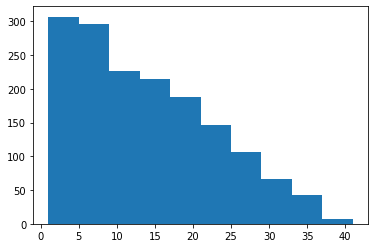

In [64]:
plt.hist(train_y)